# NBA Model Backtesting & Performance Analysis

This notebook performs a time-series backtest of the NBA prediction model.
It simulates the prediction process day-by-day to avoid data leakage and evaluates performance using various metrics.

## Goals
1. Validate model accuracy on historical data (2025 season).
2. Analyze performance metrics (Accuracy, Brier Score, Spread MSE).
3. Identify strengths and weaknesses (calibration, team-specific performance).


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sys
import os
from tqdm.notebook import tqdm

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data import nba_fetcher, nba_game_logs_loader
from src.models.predictor import GamePredictor

# Formatting
sns.set_style("whitegrid")
pd.set_option('display.float_format', '{:.3f}'.format)


: 

In [ ]:

# Configuration
SEASON = 2025
START_DATE = '2025-11-01'  # Start after some data has accumulated
END_DATE = '2026-01-05'    # Up to recent completed games

print(f"Fetching data for {SEASON} season...")
schedule = nba_fetcher.fetch_nba_schedule(SEASON)
print(f"Schedule: {len(schedule)} games")

# Load completed games
completed_games = schedule[schedule['home_score'].notna()].copy()
print(f"Completed Games: {len(completed_games)}")

# Load logs from BigQuery
print("Loading Game Logs from BigQuery...")
game_logs = nba_game_logs_loader.load_nba_game_logs_from_bq([SEASON])
if game_logs is None or game_logs.empty:
    print("WARNING: BigQuery logs empty, fetching from API (this may take time)...")
    game_logs = nba_game_logs_loader.load_nba_game_logs([SEASON], strict=True, schedule_df=schedule)

print(f"Game Logs: {len(game_logs)} entries")


Fetching data for 2025 season...


Schedule: 607 games
Completed Games: 604
Loading Game Logs from BigQuery...
Loading NBA game logs from BigQuery (learned-pier-478122-p7.sports_edge_raw.raw_nba_game_logs)...


  Successfully loaded 1217 logs from BigQuery.
Game Logs: 1217 entries


In [ ]:

def run_backtest(schedule, logs, start_date_str, end_date_str):
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d').date()
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d').date()
    
    current_date = start_date
    predictions = []
    
    predictor = GamePredictor('NBA', 'v1')
    
    pbar = tqdm(total=(end_date - start_date).days + 1)
    
    while current_date <= end_date:
        d_str = current_date.strftime('%Y-%m-%d')
        
        # Get games for today
        days_games = schedule[pd.to_datetime(schedule['game_date']).dt.date == current_date]
        
        if not days_games.empty:
            # We must only use data available BEFORE today for training/stats
            # But the 'logs' dataframe contains ALL history.
            # The predictor likely filters logs? 
            # In predict_nba_date.py, we pass the FULL logs df. 
            # Does the predictor filter strictly by date inside?
            # Let's verify: predictor.predict -> build_features
            # We need to rely on the predictor implementation to be leakage-free,
            # or we manually filter logs here.
            # To be safe, let's filter logs to < current_date.
            
            logs_cutoff = logs[pd.to_datetime(logs['game_date']).dt.date < current_date].copy()
            completed_cutoff = schedule[
                (pd.to_datetime(schedule['game_date']).dt.date < current_date) &
                (schedule['home_score'].notna())
            ].copy()
            
            # Predict
            for _, game in days_games.iterrows():
                try:
                    game_df = pd.DataFrame([game])
                    result = predictor.predict(game_df, schedule, game_logs=logs_cutoff)
                    predictions.append(result)
                except Exception as e:
                    # Often due to missing history for a team
                    pass
                    
        current_date += timedelta(days=1)
        pbar.update(1)
        
    pbar.close()
    return pd.DataFrame(predictions)

print("Starting Backtest...")
results_df = run_backtest(schedule, game_logs, START_DATE, END_DATE)
print(f"Generated {len(results_df)} predictions.")


Starting Backtest...


  0%|          | 0/66 [00:00<?, ?it/s]

Generated 456 predictions.


In [ ]:

# Evaluation Metrics
if not results_df.empty:
    # Join with actual results
    # results_df has 'predicted_winner', 'predicted_spread', etc. but maybe not scores
    
    # Ensure date format matches for merge
    results_df['game_date'] = pd.to_datetime(results_df['game_date'])
    schedule['game_date'] = pd.to_datetime(schedule['game_date'])
    
    # Merge with schedule to get actual scores
    # use left join on date/home/away
    results_df = results_df.merge(
        schedule[['game_date', 'home_team', 'away_team', 'home_score', 'away_score']], 
        on=['game_date', 'home_team', 'away_team'], 
        how='left'
    )

    # Add actuals
    results_df['actual_home_score'] = pd.to_numeric(results_df['home_score'])
    results_df['actual_away_score'] = pd.to_numeric(results_df['away_score'])

    results_df['actual_margin'] = results_df['actual_home_score'] - results_df['actual_away_score']
    results_df['actual_winner'] = np.where(results_df['actual_margin'] > 0, results_df['home_team'], results_df['away_team'])
    results_df['home_win'] = (results_df['actual_margin'] > 0).astype(int)
    
    # Calculate Correctness
    results_df['is_correct'] = results_df['predicted_winner'] == results_df['actual_winner']
    
    # Brier Score (using home_win_probability)
    # Brier = (prob - outcome)^2
    results_df['brier_score'] = (results_df['home_win_probability'] - results_df['home_win'])**2
    
    # Log Loss
    # handling 0/1 to avoid inf
    epsilon = 1e-15
    pred_prob = np.clip(results_df['home_win_probability'], epsilon, 1 - epsilon)
    results_df['log_loss'] = -(results_df['home_win'] * np.log(pred_prob) + (1 - results_df['home_win']) * np.log(1 - pred_prob))
    
    # Spread Error (Predicted spread is home_margin)
    # In predictor: predicted_spread usually means Home Advantage (Home - Away) OR Away Advantage?
    # predict_nba_date.py says: predicted_home_margin = -pred['predicted_spread']
    # Let's check: "Spread: -5.61 (IND by 5.6)". If CLE @ IND. Home=IND.
    # If Spread is -5.6, and Interpretation is IND by 5.6.
    # Usually negative spread means FAVORITE.
    # If IND is Home and Favorite, then IND score > CLE score.
    # So Actual Margin (Home - Away) should be Positive.
    # So Negative Spread -> Positive Margin?
    # This implies predicted_margin = -predicted_spread.
    
    results_df['predicted_margin'] = -results_df['predicted_spread']
    results_df['spread_error'] = results_df['predicted_margin'] - results_df['actual_margin']
    results_df['abs_spread_error'] = results_df['spread_error'].abs()
    results_df['sq_spread_error'] = results_df['spread_error']**2
    
    # Summary
    print("=== Model Performance ===")
    print(f"Accuracy: {results_df['is_correct'].mean():.2%}")
    print(f"Brier Score: {results_df['brier_score'].mean():.4f}")
    print(f"Log Loss: {results_df['log_loss'].mean():.4f}")
    print(f"MAE (Spread): {results_df['abs_spread_error'].mean():.2f}")
    print(f"RMSE (Spread): {np.sqrt(results_df['sq_spread_error'].mean()):.2f}")
else:
    print("No predictions generated.")


=== Model Performance ===
Accuracy: 61.40%
Brier Score: 0.2386
Log Loss: 0.6705
MAE (Spread): 12.06
RMSE (Spread): 15.03


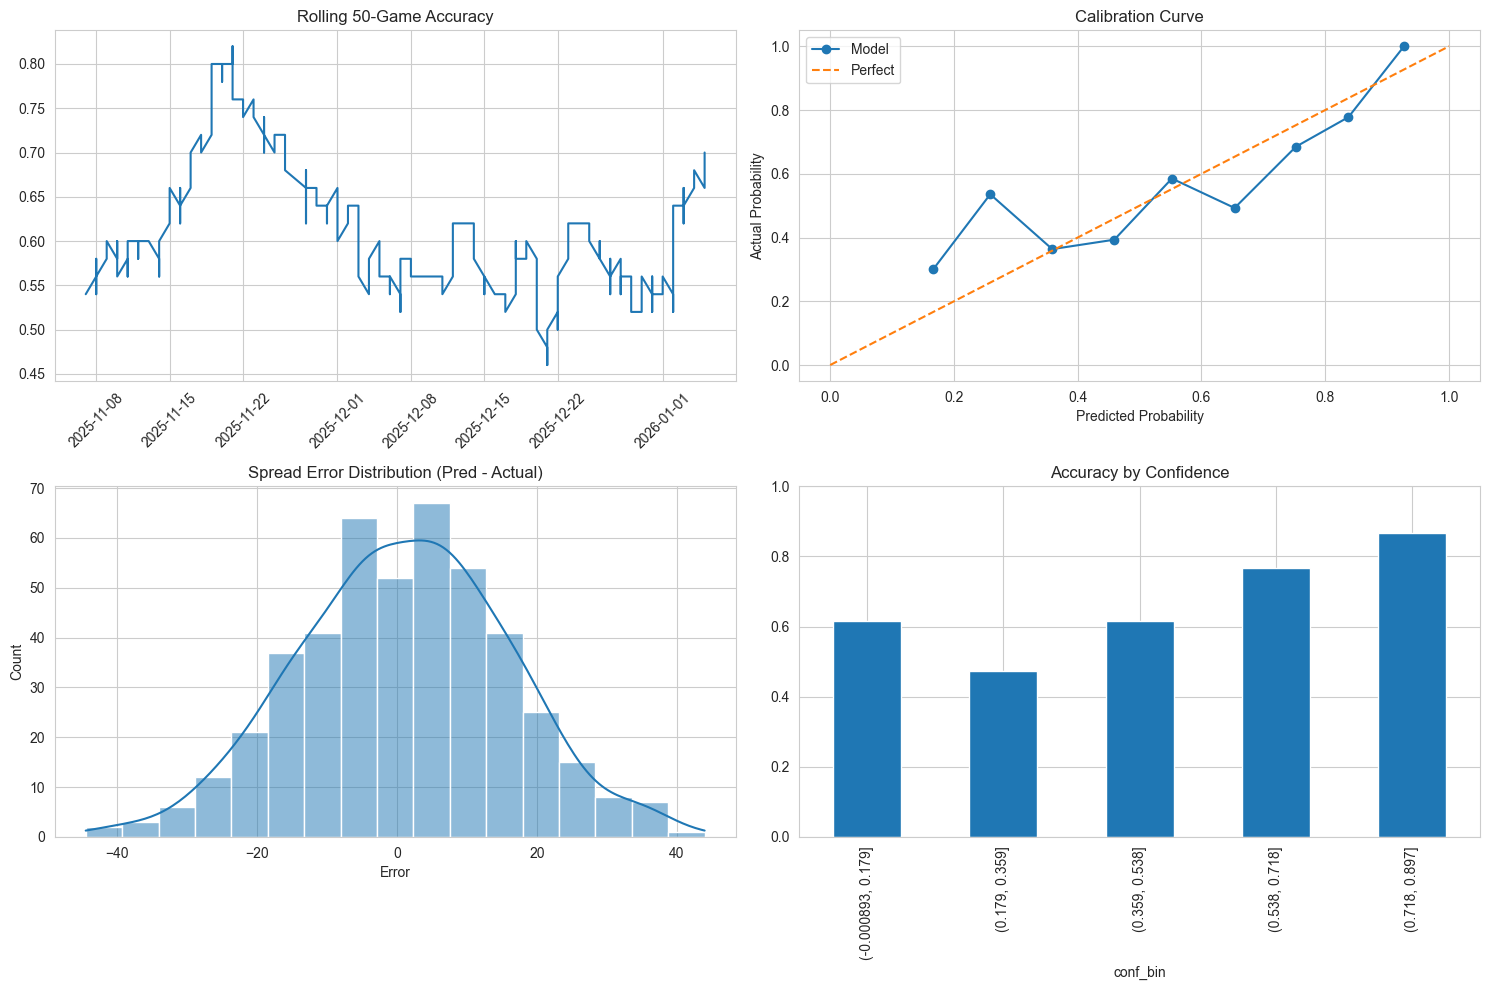

In [ ]:

# Visualizations
if not results_df.empty:
    plt.figure(figsize=(15, 10))
    
    # 1. Rolling Accuracy
    plt.subplot(2, 2, 1)
    results_df.sort_values('game_date', inplace=True)
    rolling_acc = results_df['is_correct'].rolling(window=50).mean()
    plt.plot(results_df['game_date'], rolling_acc)
    plt.title('Rolling 50-Game Accuracy')
    plt.xticks(rotation=45)
    
    # 2. Calibration Curve
    plt.subplot(2, 2, 2)
    from sklearn.calibration import calibration_curve
    prob_true, prob_pred = calibration_curve(results_df['home_win'], results_df['home_win_probability'], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Actual Probability')
    plt.title('Calibration Curve')
    plt.legend()
    
    # 3. Spread Error Distribution
    plt.subplot(2, 2, 3)
    sns.histplot(results_df['spread_error'], kde=True)
    plt.title('Spread Error Distribution (Pred - Actual)')
    plt.xlabel('Error')
    
    # 4. Confidence vs Accuracy
    plt.subplot(2, 2, 4)
    results_df['conf_bin'] = pd.cut(results_df['confidence'], bins=5)
    conf_acc = results_df.groupby('conf_bin', observed=False)['is_correct'].mean()
    conf_acc.plot(kind='bar')
    plt.title('Accuracy by Confidence')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
